In [43]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from tqdm import tqdm
import gc
from numba import jit
from matplotlib import pyplot as plt

In [7]:
def _clean(x, default='float'):   
    non_default = 'int' if default=='float' else 'float'
    try:
        x.replace([np.inf, -np.inf], np.nan, inplace=True)
        x.dropna(how='all', axis=1, inplace=True)
        if default=='float':
            x = x * 1.0
        else:
            x = x * 1
    except Exception as e:
        print(e)
        for col in tqdm.tqdm(x.columns):
            if 'object' in str(x[col].dtypes):
                try:
                    x[col] = x[col].astype(default)
                except:
                    try:
                        x[col] = x[col].astype(non_default)
                    except:
                        print(col)
                        x[col] = x[col].astype('category')
    return x

def get_transposed(df, NameRow='GenX', prefix='GenX'):
    transposed  = df.T
    new_index = transposed.loc[[NameRow]].values.tolist()[0]
    transposed.columns = new_index
    if prefix is not None:
        transposed.columns = [prefix+'_'+_col for _col in transposed.columns.values.tolist()]
    return transposed.drop(NameRow, axis=0, inplace=False)

# def _impute(df, type='FM):
#   # use similarity to replace missing values with values for most similar patients.

In [8]:
# loading data

In [9]:
pheno_small = pd.read_csv("../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_large = pd.read_csv("../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)

In [11]:
sourceDir = "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/"  #"/media/bramvanes/Extra/DATA/RexR/2018" #
gene_expression = pd.read_table(sourceDir+"/Lung/Lung_GeneExpression.txt", sep="\t")

affx_labels = list(gene_expression.set_index('Gene').filter(axis=0, regex=r"^(AFFX.*)").index) # AFFX 
gene_expression = gene_expression.drop(affx_labels, axis=0)

gene_expression = gene_expression[np.isfinite(gene_expression.Start)]
gene_expression = gene_expression[np.isfinite(gene_expression.Stop)]

gene_expression.Start = gene_expression.Start.astype(int).astype(str)
gene_expression.Stop = gene_expression.Stop.astype(int).astype(str)
gene_expression.Chr = gene_expression.Chr.astype(str)
gene_expression.Gene = gene_expression.Gene.astype(str)

gene_expression['GenX'] = gene_expression[['Gene', 'Chr', 'Start', 'Stop']].apply(lambda x: '.'.join(x), axis=1)
_map_RNA = gene_expression[['Gene', 'GenX']]
gene_expression = gene_expression.drop(['Gene', 'Chr', 'Start', 'Stop'], axis=1)

# remove duplicate GenX values
gene_expression = gene_expression.copy().loc[~gene_expression.GenX.duplicated(keep='first')]

dict_RNA={'RNA_StrandPlus': _clean(get_transposed(gene_expression\
                                                  .loc[gene_expression.Strand=='+'].drop(['Strand'], axis=1))),
          'RNA_StrandMin':  _clean(get_transposed(gene_expression\
                                                  .loc[gene_expression.Strand=='-'].drop(['Strand'], axis=1)))                                
          }


In [12]:
# CLEAN MEMORY
del gene_expression
gc.collect()

7

In [13]:
# merge with phenotypes
pheno_features = ['batch_number', 'code.tissue_source_site', 'sample_type.samples', 'vial_number', 'ethnicity.demographic', 'gender.demographic',
                   'race.demographic', 'year_of_birth.demographic', 'diagnosis']

In [14]:
merged_RNA_min = dict_RNA['RNA_StrandMin'].merge(pheno_large[pheno_features], how='left', left_index=True, right_index=True)
merged_RNA_plus = dict_RNA['RNA_StrandPlus'].merge(pheno_large[pheno_features], how='left', left_index=True, right_index=True)

In [16]:
# There are patients with multiple measurements, we simply take the mean 
gene_columns = [_col for _col in merged_RNA_min.columns if 'GenX' in _col]
other_columns = [_col for _col in merged_RNA_min.columns if 'GenX' not in _col]

merged_RNA_min['patient_nr'] = merged_RNA_min.index
tmp_min = merged_RNA_min[['patient_nr']+gene_columns].groupby(by='patient_nr').mean()
merged_RNA_min = merged_RNA_min.copy()[other_columns].merge(tmp_min, how='right', left_index=True, right_on='patient_nr')
merged_RNA_min = merged_RNA_min.loc[~merged_RNA_min.index.duplicated(keep='first')]

gene_columns = [_col for _col in merged_RNA_plus.columns if 'GenX' in _col]
other_columns = [_col for _col in merged_RNA_plus.columns if 'GenX' not in _col]

merged_RNA_plus['patient_nr'] = merged_RNA_plus.index
tmp_plus = merged_RNA_plus[['patient_nr']+gene_columns].groupby(by='patient_nr').mean()
merged_RNA_plus = merged_RNA_plus.copy()[other_columns].merge(tmp_plus, how='right', left_index=True, right_on='patient_nr')
merged_RNA_plus = merged_RNA_plus.loc[~merged_RNA_plus.index.duplicated(keep='first')]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: 'patient_nr' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


# Bias correction functions
## L/S, cohort-based normalisation

Mean-based $$\mathbf{x}^*=\frac{\mathbf{x}-\overline{\mathbf{x}}}{\sigma}$$


Median-based $$\mathbf{x}^*=\frac{\mathbf{x}-median(\mathbf{x})}{IQR}$$






In [17]:
# L/S
def _preprocess(df, cohorts = [], scaler = "standard", bias_removal = False, col_range = None, min_cohort_size=10, debug=False):
        if col_range is None:
            gene_columns = [_col for _col in df.columns if 'GenX' in _col]  
        else:                      
            cr = range(col_range[0], col_range[1])
            gene_columns = df.columns[cr]
        
        if len(cohorts)==0:
            cohorts = df.batch_number.unique().tolist()
        
        # MinMaxScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer(), Normalizer()
        if scaler == "standard":
            scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
        elif scaler == "minmax":
            scaler = preprocessing.MinMaxScaler()
        elif scaler == "maxabs":
            scaler = preprocessing.MaxAbsScaler()
        elif scaler == "robust":
            scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0), 
                                                    with_scaling=True, with_centering=True)
        elif scaler in ["normalizer", "normaliser"]:
            scaler = preprocessing.Normalizer()

        if bias_removal == True:
            print("- "*30, 'Removing cohort biases')
            i=0; itot=len(cohorts)
            
            for cohort in cohorts: # easy to parallelise...
                i+=1
                ch = df['batch_number']==cohort
                if sum(ch)<min_cohort_size:
                    print("Skipping cohort {}, because of low sample count: {}".format(cohort, sum(ch)))
                else:
                    if debug==False:
                        try:
                            res = scaler.fit_transform(df.loc[ch,gene_columns].values)
                            df.loc[ch,gene_columns] = pd.DataFrame(data=res, index=ch[ch].index, columns=gene_columns)
                            print("{}/{}, Corrected cohort {}, with {} samples".format(i, itot, cohort, sum(ch))) 
                        except Exception as e:
                            print("ERROR", e, "cohort:"+cohort)
                            print("index:",ch)
                            print("target:", df.loc[ch,gene_columns].shape) 
                            print("replacement:", res.shape)
                    else:
                        for _col in gene_columns: # for debugging
                            df_temp = df.loc[ch, _col].copy() 
                            try:
                                df.loc[ch, _col] = (df_temp-df_temp.mean())/df_temp.std()
                            except Exception as e:
                                print("ERROR", e, "gene:"+_col, "cohort:"+cohort)
        else:
            ch = df["array-batch"].isin(cohorts)
            df.loc[ch,gene_columns] = scaler.fit_transform(df.loc[ch,gene_columns])
            

        df = df[df["batch_number"].isin(cohorts)]
        return df       

In [18]:
merged_RNA_plus_CBC_LS = _preprocess(merged_RNA_plus.copy(), col_range=None, bias_removal=True, debug=False) # 29905

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
Transformation done..assigning values
1/43, Corrected cohort 52.73.0, with 15 samples
Transformation done..assigning values
2/43, Corrected cohort 58.76.0, with 39 samples
Transformation done..assigning values
3/43, Corrected cohort 119.75.0, with 54 samples
Transformation done..assigning values
4/43, Corrected cohort 144.69.0, with 52 samples
Transformation done..assigning values
5/43, Corrected cohort 84.72.0, with 31 samples
Transformation done..assigning values
6/43, Corrected cohort 39.67.0, with 36 samples
Transformation done..assigning values
7/43, Corrected cohort 77.67.0, with 26 samples
Transformation done..assigning values
8/43, Corrected cohort 53.65.0, with 13 samples
Transformation done..assigning values
9/43, Corrected cohort 101.61.0, with 29 samples
Transformation done..assigning values
10/43, Corrected cohort 23.74.0, with 22 samples
Skipping cohort 208.52.0, because of low sample coun

In [48]:
merged_RNA_plus_CBC_LS_MINMAX = _preprocess(merged_RNA_plus.copy(), col_range=None, 
                                            bias_removal=True, debug=False, scaler='minmax') # 29905

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
Transformation done..assigning values
1/43, Corrected cohort 52.73.0, with 15 samples
Transformation done..assigning values
2/43, Corrected cohort 58.76.0, with 39 samples
Transformation done..assigning values
3/43, Corrected cohort 119.75.0, with 54 samples
Transformation done..assigning values
4/43, Corrected cohort 144.69.0, with 52 samples
Transformation done..assigning values
5/43, Corrected cohort 84.72.0, with 31 samples
Transformation done..assigning values
6/43, Corrected cohort 39.67.0, with 36 samples
Transformation done..assigning values
7/43, Corrected cohort 77.67.0, with 26 samples
Transformation done..assigning values
8/43, Corrected cohort 53.65.0, with 13 samples
Transformation done..assigning values
9/43, Corrected cohort 101.61.0, with 29 samples
Transformation done..assigning values
10/43, Corrected cohort 23.74.0, with 22 samples
Skipping cohort 208.52.0, because of low sample coun

In [54]:
merged_RNA_min_CBC_LS = _preprocess(merged_RNA_min.copy(), col_range=None, bias_removal=True, debug=False) # 29905

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
Transformation done..assigning values
1/43, Corrected cohort 52.73.0, with 15 samples
Transformation done..assigning values
2/43, Corrected cohort 58.76.0, with 39 samples
Transformation done..assigning values
3/43, Corrected cohort 119.75.0, with 54 samples
Transformation done..assigning values
4/43, Corrected cohort 144.69.0, with 52 samples
Transformation done..assigning values
5/43, Corrected cohort 84.72.0, with 31 samples
Transformation done..assigning values
6/43, Corrected cohort 39.67.0, with 36 samples
Transformation done..assigning values
7/43, Corrected cohort 77.67.0, with 26 samples
Transformation done..assigning values
8/43, Corrected cohort 53.65.0, with 13 samples
Transformation done..assigning values
9/43, Corrected cohort 101.61.0, with 29 samples
Transformation done..assigning values
10/43, Corrected cohort 23.74.0, with 22 samples
Skipping cohort 208.52.0, because of low sample coun

Text(0.5,1,'Cohort comparison for GenX_CD99.chrX.2691179.2741309 using standard scaling (left), versus no scaling (right)')

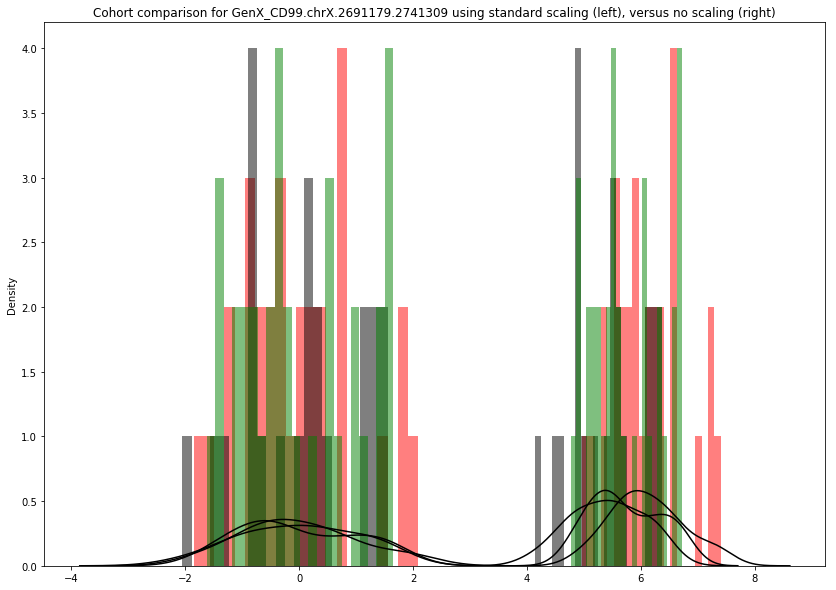

In [51]:
test_gene = 'GenX_CD99.chrX.2691179.2741309'
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='101.61.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='red')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='196.63.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='black')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='264.59.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='green')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='101.61.0'][test_gene]\
                .plot.kde(color='black')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='196.63.0'][test_gene]\
                .plot.kde(color='black')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='264.59.0'][test_gene]\
                .plot.kde(color='black')

merged_RNA_plus_CBC_LS.loc[merged_RNA_plus_CBC_LS.batch_number=='101.61.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='red')
merged_RNA_plus_CBC_LS.loc[merged_RNA_plus_CBC_LS.batch_number=='196.63.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='black')
merged_RNA_plus_CBC_LS.loc[merged_RNA_plus_CBC_LS.batch_number=='264.59.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='green')
merged_RNA_plus_CBC_LS.loc[merged_RNA_plus_CBC_LS.batch_number=='101.61.0'][test_gene]\
                .plot.kde(color='black')
merged_RNA_plus_CBC_LS.loc[merged_RNA_plus_CBC_LS.batch_number=='196.63.0'][test_gene]\
                .plot.kde(color='black')
merged_RNA_plus_CBC_LS.loc[merged_RNA_plus_CBC_LS.batch_number=='264.59.0'][test_gene]\
                .plot.kde(color='black')

plt.title('Cohort comparison for {} using standard scaling (left), versus no scaling (right)'.format(test_gene))

Text(0.5,1,'Cohort comparison for GenX_CD99.chrX.2691179.2741309 using minmax scaling (left), versus no scaling (right)')

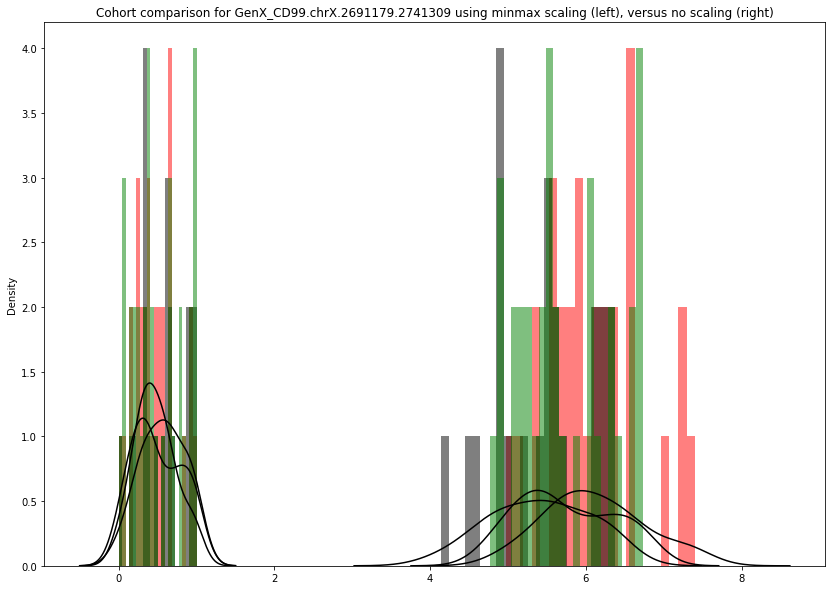

In [53]:

test_gene = 'GenX_CD99.chrX.2691179.2741309'
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='101.61.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='red')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='196.63.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='black')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='264.59.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='green')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='101.61.0'][test_gene]\
                .plot.kde(color='black')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='196.63.0'][test_gene]\
                .plot.kde(color='black')
merged_RNA_plus.loc[merged_RNA_plus.batch_number=='264.59.0'][test_gene]\
                .plot.kde(color='black')


merged_RNA_plus_CBC_LS_MINMAX.loc[merged_RNA_plus_CBC_LS_MINMAX.batch_number=='101.61.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='red')
merged_RNA_plus_CBC_LS_MINMAX.loc[merged_RNA_plus_CBC_LS_MINMAX.batch_number=='196.63.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='black')
merged_RNA_plus_CBC_LS_MINMAX.loc[merged_RNA_plus_CBC_LS_MINMAX.batch_number=='264.59.0'][test_gene]\
                .plot.hist(alpha=0.5, bins=22, figsize=(14,10), color='green')
merged_RNA_plus_CBC_LS_MINMAX.loc[merged_RNA_plus_CBC_LS_MINMAX.batch_number=='101.61.0'][test_gene]\
                .plot.kde(color='black')
merged_RNA_plus_CBC_LS_MINMAX.loc[merged_RNA_plus_CBC_LS_MINMAX.batch_number=='196.63.0'][test_gene]\
                .plot.kde(color='black')
merged_RNA_plus_CBC_LS_MINMAX.loc[merged_RNA_plus_CBC_LS_MINMAX.batch_number=='264.59.0'][test_gene]\
                .plot.kde(color='black')

plt.title('Cohort comparison for {} using minmax scaling (left), versus no scaling (right)'.format(test_gene))

In [ ]:
## PCA-shift

## ANOVA 2-way

## Combat
# use R-script, call from PYthon